## Import data & libraries

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
#import missingno as msno
#from google.colab import data_table
#from tabulate import tabulate
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

from mlxtend.feature_selection import ExhaustiveFeatureSelector

In [28]:
final_df = pd.read_csv('data/2_de_cada.csv',index_col=0).reset_index(drop=True)
final_df
#como no tenemos muchos datos gratis de git stars y social volume, las quitamos

,Date,next_day_closing_price,Social_Volume_AI,weighted_sentiment,Social_Volume_AI sma 3,Social_Volume_AI sma 5,Social_Volume_AI sma 7,Social_Volume_AI sma 10,Social_Volume_AI sma 15,Social_Volume_AI sma 30,Social_Volume_AI sma 60,Social_Volume_AI sma 90,weighted_sentiment sma 3,weighted_sentiment sma 5,weighted_sentiment sma 7,weighted_sentiment sma 10,weighted_sentiment sma 15,weighted_sentiment sma 30,weighted_sentiment sma 60,weighted_sentiment sma 90,Social_Volume_AI wma3,Social_Volume_AI wma5,Social_Volume_AI wma7,Social_Volume_AI wma10,Social_Volume_AI wma15,Social_Volume_AI wma30,Social_Volume_AI wma60,Social_Volume_AI wma90,weighted_sentiment wma3,weighted_sentiment wma5,weighted_sentiment wma7,weighted_sentiment wma10,weighted_sentiment wma15,weighted_sentiment wma30,weighted_sentiment wma60,weighted_sentiment wma90,Social_Volume_AI ema3,Social_Volume_AI ema5,Social_Volume_AI ema7,Social_Volume_AI ema10,Social_Volume_AI ema15,Social_Volume_AI ema30,Social_Volume_AI ema60,Social_Volume_AI ema90,weighted_sentiment ema3,weighted_sentiment ema5,weighted_sentiment ema7,weighted_sentiment ema10,weighted_sentiment ema15,weighted_sentiment ema30,weighted_sentiment ema60,weighted_sentiment ema90,Social_Volume_AI dema3,Social_Volume_AI dema5,Social_Volume_AI dema7,Social_Volume_AI dema10,Social_Volume_AI dema15,Social_Volume_AI dema30,Social_Volume_AI dema60,Social_Volume_AI dema90,weighted_sentiment dema3,weighted_sentiment dema5,weighted_sentiment dema7,weighted_sentiment dema10,weighted_sentiment dema15,weighted_sentiment dema30,weighted_sentiment dema60,weighted_sentiment dema90,Social_Volume_AI tema3,Social_Volume_AI tema5,Social_Volume_AI tema7,Social_Volume_AI tema10,Social_Volume_AI tema15,Social_Volume_AI tema30,Social_Volume_AI tema60,Social_Volume_AI tema90,weighted_sentiment tema3,weighted_sentiment tema5,weighted_sentiment tema7,weighted_sentiment tema10,weighted_sentiment tema15,weighted_sentiment tema30,weighted_sentiment tema60,weighted_sentiment tema90,Social_Volume_AI stdev3,Social_Volume_AI stdev5,Social_Volume_AI stdev7,Social_Volume_AI stdev10,Social_Volume_AI stdev15,Social_Volume_AI stdev30,Social_Volume_AI stdev60,Social_Volume_AI stdev90,weighted_sentiment stdev3,weighted_sentiment stdev5,weighted_sentiment stdev7,weighted_sentiment stdev10,weighted_sentiment stdev15,weighted_sentiment stdev30,weighted_sentiment stdev60,weighted_sentiment stdev90,Social_Volume_AI var3,Social_Volume_AI var5,Social_Volume_AI var7,Social_Volume_AI var10,Social_Volume_AI var15,Social_Volume_AI var30,Social_Volume_AI var60,Social_Volume_AI var90,weighted_sentiment var3,weighted_sentiment var5,weighted_sentiment var7,weighted_sentiment var10,weighted_sentiment var15,weighted_sentiment var30,weighted_sentiment var60,weighted_sentiment var90,Social_Volume_AI rsi3,Social_Volume_AI rsi5,Social_Volume_AI rsi7,Social_Volume_AI rsi10,Social_Volume_AI rsi15,Social_Volume_AI rsi30,Social_Volume_AI rsi60,Social_Volume_AI rsi90,weighted_sentiment rsi3,weighted_sentiment rsi5,weighted_sentiment rsi7,weighted_sentiment rsi10,weighted_sentiment rsi15,weighted_sentiment rsi30,weighted_sentiment rsi60,weighted_sentiment rsi90,Social_Volume_AI roc3,Social_Volume_AI roc5,Social_Volume_AI roc7,Social_Volume_AI roc10,Social_Volume_AI roc15,Social_Volume_AI roc30,Social_Volume_AI roc60,Social_Volume_AI roc90,weighted_sentiment roc3,weighted_sentiment roc5,weighted_sentiment roc7,weighted_sentiment roc10,weighted_sentiment roc15,weighted_sentiment roc30,weighted_sentiment roc60,weighted_sentiment roc90,Social_Volume_AI bband_lower3,Social_Volume_AI bband_lower5,Social_Volume_AI bband_lower7,Social_Volume_AI bband_lower10,Social_Volume_AI bband_lower15,Social_Volume_AI bband_lower30,Social_Volume_AI bband_lower60,Social_Volume_AI bband_lower90,weighted_sentiment bband_lower3,weighted_sentiment bband_lower5,weighted_sentiment bband_lower7,weighted_sentiment bband_lower10,weighted_sentiment bband_lower15,weighted_sentiment bband_lower30,weighted_sent

In [29]:
def feature_imp(df,feat_importance,n_select_features):
    feat_imp_df = pd.DataFrame(data = {"Feature Name": df.columns,"Feature Importance":feat_importance})

    feat_imp_df = feat_imp_df.sort_values("Feature Importance",ascending=False)[:n_select_features]

    fig,ax = plt.subplots(figsize=(14,12))
    ax = sns.barplot(x = "Feature Importance",y = "Feature Name",
                    data=feat_imp_df,palette="nipy_spectral")
    plt.title('Feature Importances')

    cmap = plt.get_cmap('nipy_spectral_r',n_select_features)
    minfi = min(feat_imp_df['Feature Importance'])
    maxfi = max(feat_imp_df['Feature Importance'])
    #https://stackoverflow.com/a/43807666
    norm = mpl.colors.Normalize(vmin=minfi,vmax=maxfi)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    # plt.colorbar(sm,ticks=np.linspace(minfi,maxfi,n_select_features),
    #             boundaries=np.arange(minfi,maxfi+0.001,.0001))
    ax.xaxis.grid()
    plt.show()
    return feat_imp_df,df[feat_imp_df['Feature Name']]

In [30]:
pd.set_option('display.max_columns', None)
final_df.describe()


,next_day_closing_price,Social_Volume_AI,weighted_sentiment,Social_Volume_AI sma 3,Social_Volume_AI sma 5,Social_Volume_AI sma 7,Social_Volume_AI sma 10,Social_Volume_AI sma 15,Social_Volume_AI sma 30,Social_Volume_AI sma 60,Social_Volume_AI sma 90,weighted_sentiment sma 3,weighted_sentiment sma 5,weighted_sentiment sma 7,weighted_sentiment sma 10,weighted_sentiment sma 15,weighted_sentiment sma 30,weighted_sentiment sma 60,weighted_sentiment sma 90,Social_Volume_AI wma3,Social_Volume_AI wma5,Social_Volume_AI wma7,Social_Volume_AI wma10,Social_Volume_AI wma15,Social_Volume_AI wma30,Social_Volume_AI wma60,Social_Volume_AI wma90,weighted_sentiment wma3,weighted_sentiment wma5,weighted_sentiment wma7,weighted_sentiment wma10,weighted_sentiment wma15,weighted_sentiment wma30,weighted_sentiment wma60,weighted_sentiment wma90,Social_Volume_AI ema3,Social_Volume_AI ema5,Social_Volume_AI ema7,Social_Volume_AI ema10,Social_Volume_AI ema15,Social_Volume_AI ema30,Social_Volume_AI ema60,Social_Volume_AI ema90,weighted_sentiment ema3,weighted_sentiment ema5,weighted_sentiment ema7,weighted_sentiment ema10,weighted_sentiment ema15,weighted_sentiment ema30,weighted_sentiment ema60,weighted_sentiment ema90,Social_Volume_AI dema3,Social_Volume_AI dema5,Social_Volume_AI dema7,Social_Volume_AI dema10,Social_Volume_AI dema15,Social_Volume_AI dema30,Social_Volume_AI dema60,Social_Volume_AI dema90,weighted_sentiment dema3,weighted_sentiment dema5,weighted_sentiment dema7,weighted_sentiment dema10,weighted_sentiment dema15,weighted_sentiment dema30,weighted_sentiment dema60,weighted_sentiment dema90,Social_Volume_AI tema3,Social_Volume_AI tema5,Social_Volume_AI tema7,Social_Volume_AI tema10,Social_Volume_AI tema15,Social_Volume_AI tema30,Social_Volume_AI tema60,Social_Volume_AI tema90,weighted_sentiment tema3,weighted_sentiment tema5,weighted_sentiment tema7,weighted_sentiment tema10,weighted_sentiment tema15,weighted_sentiment tema30,weighted_sentiment tema60,weighted_sentiment tema90,Social_Volume_AI stdev3,Social_Volume_AI stdev5,Social_Volume_AI stdev7,Social_Volume_AI stdev10,Social_Volume_AI stdev15,Social_Volume_AI stdev30,Social_Volume_AI stdev60,Social_Volume_AI stdev90,weighted_sentiment stdev3,weighted_sentiment stdev5,weighted_sentiment stdev7,weighted_sentiment stdev10,weighted_sentiment stdev15,weighted_sentiment stdev30,weighted_sentiment stdev60,weighted_sentiment stdev90,Social_Volume_AI var3,Social_Volume_AI var5,Social_Volume_AI var7,Social_Volume_AI var10,Social_Volume_AI var15,Social_Volume_AI var30,Social_Volume_AI var60,Social_Volume_AI var90,weighted_sentiment var3,weighted_sentiment var5,weighted_sentiment var7,weighted_sentiment var10,weighted_sentiment var15,weighted_sentiment var30,weighted_sentiment var60,weighted_sentiment var90,Social_Volume_AI rsi3,Social_Volume_AI rsi5,Social_Volume_AI rsi7,Social_Volume_AI rsi10,Social_Volume_AI rsi15,Social_Volume_AI rsi30,Social_Volume_AI rsi60,Social_Volume_AI rsi90,weighted_sentiment rsi3,weighted_sentiment rsi5,weighted_sentiment rsi7,weighted_sentiment rsi10,weighted_sentiment rsi15,weighted_sentiment rsi30,weighted_sentiment rsi60,weighted_sentiment rsi90,Social_Volume_AI roc3,Social_Volume_AI roc5,Social_Volume_AI roc7,Social_Volume_AI roc10,Social_Volume_AI roc15,Social_Volume_AI roc30,Social_Volume_AI roc60,Social_Volume_AI roc90,weighted_sentiment roc3,weighted_sentiment roc5,weighted_sentiment roc7,weighted_sentiment roc10,weighted_sentiment roc15,weighted_sentiment roc30,weighted_sentiment roc60,weighted_sentiment roc90,Social_Volume_AI bband_lower3,Social_Volume_AI bband_lower5,Social_Volume_AI bband_lower7,Social_Volume_AI bband_lower10,Social_Volume_AI bband_lower15,Social_Volume_AI bband_lower30,Social_Volume_AI bband_lower60,Social_Volume_AI bband_lower90,weighted_sentiment bband_lower3,weighted_sentiment bband_lower5,weighted_sentiment bband_lower7,weighted_sentiment bband_lower10,weighted_sentiment bband_lower15,weighted_sentiment bband_lower30,weighted_sentiment

In [32]:
final_df = final_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

## Data Scaling

In [33]:
X = final_df.drop(['Date','next_day_closing_price'],axis=1)

scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[X.columns] = scaler.fit_transform(X[X.columns])

scaler = MinMaxScaler()
X_scaled[X.columns] =  scaler.fit_transform(X_scaled[X.columns])
X_scaled

,Social_Volume_AI,weighted_sentiment,Social_Volume_AI sma 3,Social_Volume_AI sma 5,Social_Volume_AI sma 7,Social_Volume_AI sma 10,Social_Volume_AI sma 15,Social_Volume_AI sma 30,Social_Volume_AI sma 60,Social_Volume_AI sma 90,weighted_sentiment sma 3,weighted_sentiment sma 5,weighted_sentiment sma 7,weighted_sentiment sma 10,weighted_sentiment sma 15,weighted_sentiment sma 30,weighted_sentiment sma 60,weighted_sentiment sma 90,Social_Volume_AI wma3,Social_Volume_AI wma5,Social_Volume_AI wma7,Social_Volume_AI wma10,Social_Volume_AI wma15,Social_Volume_AI wma30,Social_Volume_AI wma60,Social_Volume_AI wma90,weighted_sentiment wma3,weighted_sentiment wma5,weighted_sentiment wma7,weighted_sentiment wma10,weighted_sentiment wma15,weighted_sentiment wma30,weighted_sentiment wma60,weighted_sentiment wma90,Social_Volume_AI ema3,Social_Volume_AI ema5,Social_Volume_AI ema7,Social_Volume_AI ema10,Social_Volume_AI ema15,Social_Volume_AI ema30,Social_Volume_AI ema60,Social_Volume_AI ema90,weighted_sentiment ema3,weighted_sentiment ema5,weighted_sentiment ema7,weighted_sentiment ema10,weighted_sentiment ema15,weighted_sentiment ema30,weighted_sentiment ema60,weighted_sentiment ema90,Social_Volume_AI dema3,Social_Volume_AI dema5,Social_Volume_AI dema7,Social_Volume_AI dema10,Social_Volume_AI dema15,Social_Volume_AI dema30,Social_Volume_AI dema60,Social_Volume_AI dema90,weighted_sentiment dema3,weighted_sentiment dema5,weighted_sentiment dema7,weighted_sentiment dema10,weighted_sentiment dema15,weighted_sentiment dema30,weighted_sentiment dema60,weighted_sentiment dema90,Social_Volume_AI tema3,Social_Volume_AI tema5,Social_Volume_AI tema7,Social_Volume_AI tema10,Social_Volume_AI tema15,Social_Volume_AI tema30,Social_Volume_AI tema60,Social_Volume_AI tema90,weighted_sentiment tema3,weighted_sentiment tema5,weighted_sentiment tema7,weighted_sentiment tema10,weighted_sentiment tema15,weighted_sentiment tema30,weighted_sentiment tema60,weighted_sentiment tema90,Social_Volume_AI stdev3,Social_Volume_AI stdev5,Social_Volume_AI stdev7,Social_Volume_AI stdev10,Social_Volume_AI stdev15,Social_Volume_AI stdev30,Social_Volume_AI stdev60,Social_Volume_AI stdev90,weighted_sentiment stdev3,weighted_sentiment stdev5,weighted_sentiment stdev7,weighted_sentiment stdev10,weighted_sentiment stdev15,weighted_sentiment stdev30,weighted_sentiment stdev60,weighted_sentiment stdev90,Social_Volume_AI var3,Social_Volume_AI var5,Social_Volume_AI var7,Social_Volume_AI var10,Social_Volume_AI var15,Social_Volume_AI var30,Social_Volume_AI var60,Social_Volume_AI var90,weighted_sentiment var3,weighted_sentiment var5,weighted_sentiment var7,weighted_sentiment var10,weighted_sentiment var15,weighted_sentiment var30,weighted_sentiment var60,weighted_sentiment var90,Social_Volume_AI rsi3,Social_Volume_AI rsi5,Social_Volume_AI rsi7,Social_Volume_AI rsi10,Social_Volume_AI rsi15,Social_Volume_AI rsi30,Social_Volume_AI rsi60,Social_Volume_AI rsi90,weighted_sentiment rsi3,weighted_sentiment rsi5,weighted_sentiment rsi7,weighted_sentiment rsi10,weighted_sentiment rsi15,weighted_sentiment rsi30,weighted_sentiment rsi60,weighted_sentiment rsi90,Social_Volume_AI roc3,Social_Volume_AI roc5,Social_Volume_AI roc7,Social_Volume_AI roc10,Social_Volume_AI roc15,Social_Volume_AI roc30,Social_Volume_AI roc60,Social_Volume_AI roc90,weighted_sentiment roc3,weighted_sentiment roc5,weighted_sentiment roc7,weighted_sentiment roc10,weighted_sentiment roc15,weighted_sentiment roc30,weighted_sentiment roc60,weighted_sentiment roc90,Social_Volume_AI bband_lower3,Social_Volume_AI bband_lower5,Social_Volume_AI bband_lower7,Social_Volume_AI bband_lower10,Social_Volume_AI bband_lower15,Social_Volume_AI bband_lower30,Social_Volume_AI bband_lower60,Social_Volume_AI bband_lower90,weighted_sentiment bband_lower3,weighted_sentiment bband_lower5,weighted_sentiment bband_lower7,weighted_sentiment bband_lower10,weighted_sentiment bband_lower15,weighted_sentiment bband_lower30,weighted_sentiment bband_lower60,weighted

In [34]:
y = final_df['next_day_closing_price']
rf = RandomForestRegressor(n_estimators=2000,n_jobs=-1,bootstrap=True,
                           verbose=5,random_state=42)
rf.fit(X_scaled,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.


building tree 1 of 2000
building tree 2 of 2000
building tree 3 of 2000
building tree 4 of 2000
building tree 5 of 2000
building tree 6 of 2000
building tree 7 of 2000
building tree 8 of 2000building tree 9 of 2000building tree 10 of 2000
building tree 11 of 2000
building tree 12 of 2000

building tree 13 of 2000
building tree 14 of 2000

building tree 15 of 2000
building tree 16 of 2000
building tree 17 of 2000building tree 18 of 2000building tree 19 of 2000


building tree 20 of 2000
building tree 21 of 2000
building tree 22 of 2000
building tree 23 of 2000
building tree 24 of 2000
building tree 25 of 2000
building tree 26 of 2000
building tree 27 of 2000
building tree 28 of 2000
building tree 29 of 2000
building tree 30 of 2000
building tree 31 of 2000
building tree 32 of 2000
building tree 33 of 2000
building tree 34 of 2000
building tree 35 of 2000
building tree 36 of 2000
building tree 37 of 2000
building tree 38 of 2000
building tree 39 of 2000
building tree 40 of 2000
building 

[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.5s


building tree 56 of 2000building tree 57 of 2000

building tree 58 of 2000
building tree 59 of 2000
building tree 60 of 2000
building tree 61 of 2000
building tree 62 of 2000
building tree 63 of 2000
building tree 64 of 2000
building tree 65 of 2000
building tree 66 of 2000
building tree 67 of 2000
building tree 68 of 2000
building tree 69 of 2000building tree 70 of 2000

building tree 71 of 2000
building tree 72 of 2000
building tree 73 of 2000
building tree 74 of 2000
building tree 75 of 2000
building tree 76 of 2000
building tree 77 of 2000
building tree 78 of 2000
building tree 79 of 2000
building tree 80 of 2000
building tree 81 of 2000
building tree 82 of 2000
building tree 83 of 2000
building tree 84 of 2000
building tree 85 of 2000
building tree 86 of 2000
building tree 87 of 2000
building tree 88 of 2000
building tree 89 of 2000
building tree 90 of 2000
building tree 91 of 2000
building tree 92 of 2000
building tree 93 of 2000
building tree 94 of 2000
building tree 95 of 2000


[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:    6.3s


building tree 148 of 2000
building tree 149 of 2000
building tree 150 of 2000
building tree 151 of 2000
building tree 152 of 2000
building tree 153 of 2000
building tree 154 of 2000
building tree 155 of 2000
building tree 156 of 2000
building tree 157 of 2000
building tree 158 of 2000
building tree 159 of 2000
building tree 160 of 2000
building tree 161 of 2000
building tree 162 of 2000
building tree 163 of 2000
building tree 164 of 2000
building tree 165 of 2000
building tree 166 of 2000
building tree 167 of 2000
building tree 168 of 2000
building tree 169 of 2000
building tree 170 of 2000
building tree 171 of 2000
building tree 172 of 2000
building tree 173 of 2000
building tree 174 of 2000
building tree 175 of 2000
building tree 176 of 2000
building tree 177 of 2000
building tree 178 of 2000
building tree 179 of 2000
building tree 180 of 2000
building tree 181 of 2000
building tree 182 of 2000building tree 183 of 2000
building tree 184 of 2000

building tree 185 of 2000
building tre

[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   10.7s


building tree 281 of 2000
building tree 282 of 2000
building tree 283 of 2000
building tree 284 of 2000
building tree 285 of 2000
building tree 286 of 2000
building tree 287 of 2000
building tree 288 of 2000
building tree 289 of 2000
building tree 290 of 2000
building tree 291 of 2000
building tree 292 of 2000
building tree 293 of 2000
building tree 294 of 2000
building tree 295 of 2000
building tree 296 of 2000
building tree 297 of 2000
building tree 298 of 2000
building tree 299 of 2000
building tree 300 of 2000
building tree 301 of 2000
building tree 302 of 2000
building tree 303 of 2000
building tree 304 of 2000
building tree 305 of 2000
building tree 306 of 2000
building tree 307 of 2000
building tree 308 of 2000
building tree 309 of 2000
building tree 310 of 2000
building tree 311 of 2000
building tree 312 of 2000
building tree 313 of 2000
building tree 314 of 2000
building tree 315 of 2000
building tree 316 of 2000
building tree 317 of 2000
building tree 318 of 2000
building tre

[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   18.9s


building tree 435 of 2000
building tree 436 of 2000
building tree 437 of 2000
building tree 438 of 2000
building tree 439 of 2000
building tree 440 of 2000
building tree 441 of 2000
building tree 442 of 2000
building tree 443 of 2000
building tree 444 of 2000
building tree 445 of 2000
building tree 446 of 2000
building tree 447 of 2000
building tree 448 of 2000
building tree 449 of 2000
building tree 450 of 2000
building tree 451 of 2000
building tree 452 of 2000
building tree 453 of 2000
building tree 454 of 2000
building tree 455 of 2000
building tree 456 of 2000
building tree 457 of 2000
building tree 458 of 2000
building tree 459 of 2000
building tree 460 of 2000
building tree 461 of 2000
building tree 462 of 2000
building tree 463 of 2000
building tree 464 of 2000
building tree 465 of 2000
building tree 466 of 2000
building tree 467 of 2000
building tree 468 of 2000
building tree 469 of 2000
building tree 470 of 2000
building tree 471 of 2000
building tree 472 of 2000
building tre

[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   28.2s


building tree 635 of 2000
building tree 636 of 2000
building tree 637 of 2000
building tree 638 of 2000
building tree 639 of 2000
building tree 640 of 2000
building tree 641 of 2000
building tree 642 of 2000
building tree 643 of 2000
building tree 644 of 2000
building tree 645 of 2000
building tree 646 of 2000
building tree 647 of 2000
building tree 648 of 2000
building tree 649 of 2000
building tree 650 of 2000
building tree 651 of 2000
building tree 652 of 2000
building tree 653 of 2000
building tree 654 of 2000
building tree 655 of 2000
building tree 656 of 2000
building tree 657 of 2000
building tree 658 of 2000
building tree 659 of 2000
building tree 660 of 2000
building tree 661 of 2000
building tree 662 of 2000
building tree 663 of 2000
building tree 664 of 2000
building tree 665 of 2000
building tree 666 of 2000
building tree 667 of 2000
building tree 668 of 2000
building tree 669 of 2000
building tree 670 of 2000
building tree 671 of 2000
building tree 672 of 2000
building tre

[Parallel(n_jobs=-1)]: Done 850 tasks      | elapsed:   38.1s


building tree 873 of 2000
building tree 874 of 2000
building tree 875 of 2000
building tree 876 of 2000
building tree 877 of 2000
building tree 878 of 2000
building tree 879 of 2000
building tree 880 of 2000
building tree 881 of 2000
building tree 882 of 2000
building tree 883 of 2000
building tree 884 of 2000
building tree 885 of 2000
building tree 886 of 2000
building tree 887 of 2000
building tree 888 of 2000
building tree 889 of 2000
building tree 890 of 2000
building tree 891 of 2000
building tree 892 of 2000
building tree 893 of 2000
building tree 894 of 2000
building tree 895 of 2000
building tree 896 of 2000
building tree 897 of 2000
building tree 898 of 2000
building tree 899 of 2000
building tree 900 of 2000
building tree 901 of 2000
building tree 902 of 2000
building tree 903 of 2000
building tree 904 of 2000
building tree 905 of 2000
building tree 906 of 2000
building tree 907 of 2000
building tree 908 of 2000
building tree 909 of 2000
building tree 910 of 2000
building tre

[Parallel(n_jobs=-1)]: Done 1120 tasks      | elapsed:   53.4s


building tree 1141 of 2000
building tree 1142 of 2000
building tree 1143 of 2000
building tree 1144 of 2000
building tree 1145 of 2000
building tree 1146 of 2000
building tree 1147 of 2000
building tree 1148 of 2000
building tree 1149 of 2000
building tree 1150 of 2000
building tree 1151 of 2000
building tree 1152 of 2000
building tree 1153 of 2000
building tree 1154 of 2000
building tree 1155 of 2000
building tree 1156 of 2000
building tree 1157 of 2000
building tree 1158 of 2000
building tree 1159 of 2000
building tree 1160 of 2000
building tree 1161 of 2000
building tree 1162 of 2000
building tree 1163 of 2000building tree 1164 of 2000

building tree 1165 of 2000
building tree 1166 of 2000
building tree 1167 of 2000
building tree 1168 of 2000
building tree 1169 of 2000
building tree 1170 of 2000
building tree 1171 of 2000
building tree 1172 of 2000
building tree 1173 of 2000
building tree 1174 of 2000
building tree 1175 of 2000
building tree 1176 of 2000
building tree 1177 of 2000
b

[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  1.1min


building tree 1444 of 2000
building tree 1445 of 2000
building tree 1446 of 2000
building tree 1447 of 2000
building tree 1448 of 2000
building tree 1449 of 2000
building tree 1450 of 2000
building tree 1451 of 2000
building tree 1452 of 2000
building tree 1453 of 2000
building tree 1454 of 2000
building tree 1455 of 2000
building tree 1456 of 2000
building tree 1457 of 2000
building tree 1458 of 2000
building tree 1459 of 2000
building tree 1460 of 2000
building tree 1461 of 2000
building tree 1462 of 2000
building tree 1463 of 2000
building tree 1464 of 2000
building tree 1465 of 2000
building tree 1466 of 2000
building tree 1467 of 2000
building tree 1468 of 2000
building tree 1469 of 2000
building tree 1470 of 2000
building tree 1471 of 2000
building tree 1472 of 2000
building tree 1473 of 2000
building tree 1474 of 2000
building tree 1475 of 2000
building tree 1476 of 2000
building tree 1477 of 2000
building tree 1478 of 2000building tree 1479 of 2000

building tree 1480 of 2000
b

building tree 1750 of 2000
building tree 1751 of 2000
building tree 1752 of 2000
building tree 1753 of 2000
building tree 1754 of 2000
building tree 1755 of 2000
building tree 1756 of 2000
building tree 1757 of 2000
building tree 1758 of 2000
building tree 1759 of 2000
building tree 1760 of 2000
building tree 1761 of 2000
building tree 1762 of 2000
building tree 1763 of 2000
building tree 1764 of 2000building tree 1765 of 2000

building tree 1766 of 2000
building tree 1767 of 2000
building tree 1768 of 2000
building tree 1769 of 2000
building tree 1770 of 2000
building tree 1771 of 2000
building tree 1772 of 2000
building tree 1773 of 2000
building tree 1774 of 2000
building tree 1775 of 2000
building tree 1776 of 2000
building tree 1777 of 2000
building tree 1778 of 2000
building tree 1779 of 2000
building tree 1780 of 2000
building tree 1781 of 2000
building tree 1782 of 2000
building tree 1783 of 2000
building tree 1784 of 2000


[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  1.4min


building tree 1785 of 2000
building tree 1786 of 2000
building tree 1787 of 2000
building tree 1788 of 2000
building tree 1789 of 2000
building tree 1790 of 2000
building tree 1791 of 2000
building tree 1792 of 2000
building tree 1793 of 2000
building tree 1794 of 2000
building tree 1795 of 2000
building tree 1796 of 2000
building tree 1797 of 2000
building tree 1798 of 2000
building tree 1799 of 2000
building tree 1800 of 2000
building tree 1801 of 2000
building tree 1802 of 2000
building tree 1803 of 2000
building tree 1804 of 2000
building tree 1805 of 2000
building tree 1806 of 2000
building tree 1807 of 2000
building tree 1808 of 2000
building tree 1809 of 2000
building tree 1810 of 2000
building tree 1811 of 2000
building tree 1812 of 2000
building tree 1813 of 2000
building tree 1814 of 2000
building tree 1815 of 2000
building tree 1816 of 2000
building tree 1817 of 2000
building tree 1818 of 2000
building tree 1819 of 2000
building tree 1820 of 2000
building tree 1821 of 2000
b

[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  1.6min finished


RandomForestRegressor(n_estimators=2000, n_jobs=-1, random_state=42, verbose=5)

In [35]:
list(range(10,60,5))

[10, 15, 20, 25, 30, 35, 40, 45, 50, 55]

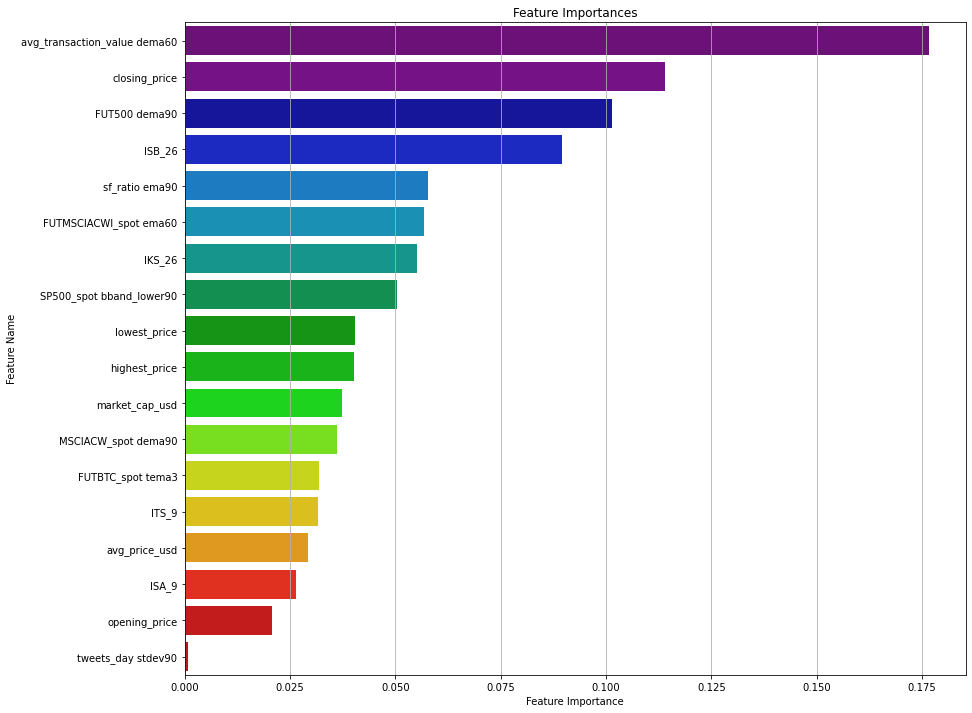

In [36]:
feat_imp_df,final_df_next_day = feature_imp(X_scaled,rf.feature_importances_,18)
final_df_next_day.insert(loc=0, column='Date', value=final_df['Date'])
final_df_next_day['next_day_closing_price'] = final_df['next_day_closing_price']
feat_imp_df.to_csv('data/feat_imp.csv',index=False)
final_df_next_day.to_csv('data/final_df_next.csv',index=False)

In [37]:
final_df_next_day.drop(['Date'],axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2982 entries, 198 to 3375
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   avg_transaction_value dema60  2982 non-null   float64
 1   closing_price                 2982 non-null   float64
 2   FUT500 dema90                 2982 non-null   float64
 3   ISB_26                        2982 non-null   float64
 4   sf_ratio ema90                2982 non-null   float64
 5   FUTMSCIACWI_spot ema60        2982 non-null   float64
 6   IKS_26                        2982 non-null   float64
 7   SP500_spot bband_lower90      2982 non-null   float64
 8   lowest_price                  2982 non-null   float64
 9   highest_price                 2982 non-null   float64
 10  market_cap_usd                2982 non-null   float64
 11  MSCIACW_spot dema90           2982 non-null   float64
 12  FUTBTC_spot tema3             2982 non-null   float64
 13  I